<a href="https://colab.research.google.com/github/Dieguito-H/APRENDIZAJE_AUTOMATICO_23_24/blob/main/A/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 1 - Ventas en Europa
**Hecho por Diego Hermana García-Agulló**

**Fecha: 05-11-2024**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
data = pd.read_csv('datos_ejercicio_ventas.csv', sep=';')
data


,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,7.543.562.371.940.470
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,5.600.305.580.289.710
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,8.850.198.084.743.070
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,3.632.245.115.157.900
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,39.617.612.049.051.800
...,...,...,...,...,...,...,...,...
18661,Great Britain,Pepsi Regular (L3),2024,2,AI_forecast,AI_P10F,2023.0,13.135.114.398.265.900
18662,Hungary,Pepsi Regular (L3),2024,7,AI_forecast,AI_P07F,2023.0,13.143.950.084.914.900
18663,Norway,7up (L3),2024,1,AI_forecast,AI_P05F,2023.0,0.0
18664,Portugal,Lipton (L3),2024,3,AI_forecast,AI_P02F,2023.0,5.330.634.036.450.760


### Contamos el número de valores reales y el número de valores inventados.


In [4]:
# Contar ocurrencias de 'actual' en la columna SCENARIO
count_actual = data['SCENARIO'].value_counts().get('actual', 0)

    # Contar ocurrencias de 'AI_forecast' en la columna SCENARIO
count_ai_forecast = data['SCENARIO'].value_counts().get('AI_forecast', 0)

count_actual


900

In [5]:
count_ai_forecast

17766

El número de valores predichos realmente en la base de datos son 900 y el número de valores predichos inventados son 17766

### Contamos el numero de paises y de productos que hay en la base de datos.

In [6]:
# Contar el número de productos distintos en la columna COUNTRY
num_paises = data['COUNTRY'].nunique()

# Contar el número de productos distintos en la columna SUBBRAND
num_productos = data['SUBBRAND'].nunique()
num_paises

9

In [7]:
num_productos

6

En la base de datos nos encontramos información sobre nueve paises distintos y de seis productos.

### Histórico de actuals.

In [8]:
# Paso 2: Mapear los códigos de pronóstico a meses
forecast_map = {
    'AI_P02F': 1, 'AI_P03F': 2, 'AI_P04F': 3, 'AI_P05F': 4,
    'AI_P06F': 5, 'AI_P07F': 6, 'AI_P08F': 7, 'AI_P09F': 8,
    'AI_P10F': 9, 'AI_P11F': 10, 'AI_P12F': 11, 'AI_PF': 12
}

# Agregar una nueva columna para el mes de pronóstico
data['FORECAST_MONTH'] = data['FORECAST'].map(forecast_map)

# Función para calcular la diferencia en meses entre la fecha de pronóstico y la fecha de los datos
def calculate_month_diff(row):
    forecast_year = row['FORECAST_YEAR']
    forecast_month = row['FORECAST_MONTH']
    data_year = row['YEAR']
    data_month = row['MONTH']

    # Calcular los meses totales para ambas fechas
    forecast_total_months = forecast_year * 12 + forecast_month
    data_total_months = data_year * 12 + data_month

    # Calcular la diferencia en meses
    return data_total_months - forecast_total_months

# Aplicar la función para calcular la diferencia de meses para cada fila
data['MONTH_DIFF'] = data.apply(calculate_month_diff, axis=1)

# Encontrar la diferencia máxima por país
max_diff_per_country = data.groupby('COUNTRY')['MONTH_DIFF'].max().reset_index()

# Mostrar el resultado
print(max_diff_per_country)

         COUNTRY  MONTH_DIFF
0          Czech        18.0
1        Denmark        18.0
2  Great Britain        18.0
3        Hungary        18.0
4          Italy        18.0
5    Netherlands        18.0
6         Norway        18.0
7       Portugal        18.0
8          Spain        18.0


In [9]:
# Filtrar para obtener solo los escenarios actuales
actual_data = data[data['SCENARIO'] == 'actual'];

# Combinar YEAR y MONTH en una nueva columna de fecha
actual_data['fecha_actual'] = pd.to_datetime(actual_data['YEAR'].astype(str) + '-' + actual_data['MONTH'].astype(str) + '-01')

# Encontrar la primera fecha
primera_fecha_actual = actual_data['fecha_actual'].min();

primera_fecha_actual

<ipython-input-9-ca3590a0172c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['fecha_actual'] = pd.to_datetime(actual_data['YEAR'].astype(str) + '-' + actual_data['MONTH'].astype(str) + '-01')


Timestamp('2023-01-01 00:00:00')

In [10]:
ultima_fecha_actual = actual_data['fecha_actual'].max()
ultima_fecha_actual

Timestamp('2024-08-01 00:00:00')

In [11]:
# Calcular la diferencia entre la última y la primera fecha
diferencia_fechas = ultima_fecha_actual - primera_fecha_actual
diferencia_meses = diferencia_fechas.days // 30
diferencia_meses

19

### Histórico de forecasts.

In [12]:
# Eliminar las filas que tienen null en la columna FORECAST
dato = data.dropna(subset=['FORECAST'])

# Paso 1: Combinar YEAR y MONTH en una columna de fecha completa
dato.loc[:,'fecha_completa'] = pd.to_datetime(dato['YEAR'].astype(str) + '-' + dato['MONTH'].astype(str) + '-01')

<ipython-input-12-cff6e7b9c7b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dato.loc[:,'fecha_completa'] = pd.to_datetime(dato['YEAR'].astype(str) + '-' + dato['MONTH'].astype(str) + '-01')


In [13]:
primera_fecha_forecast = dato['fecha_completa'].min()

In [14]:
ultima_fecha_forecast = dato['fecha_completa'].max()

In [15]:
# Calcular la diferencia entre la última y la primera fecha
diferencia_fechas = ultima_fecha_forecast - primera_fecha_forecast
diferencia_meses = diferencia_fechas.days // 30
diferencia_meses

28

### Sacamos los valores de la variable Forecast.

In [16]:
# Obtener los valores únicos de la columna FORECAST
valores_forecast = data['FORECAST'].unique()

# Mostrar los valores únicos
print(f'Los valores únicos de la columna FORECAST son: {valores_forecast}')

Los valores únicos de la columna FORECAST son: ['AI_P02F' 'AI_P10F' 'AI_P09F' 'AI_P03F' 'AI_PF' 'AI_P11F' 'AI_P06F'
 'AI_P05F' 'AI_P07F' 'AI_P12F' 'AI_P08F' 'AI_P04F' nan]


Sabemos que estos meses se entienden de la siguiente manera, AI_PnúmeroF sabiendo que el número-1 es el mes correspondiente, para el mes de diciembre no hay ningun número.

Para facilitar los siguientes ejercicios vamos a juntar las variables de YEAR y MONTH creando otra variable con el nombre de fecha y además la variable AMOUNT  la pasaremos a digitos sin "." ni exponentes.

In [17]:

# Combinar YEAR y MONTH en una nueva columna de fecha sin la hora
data['fecha'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'].astype(str) + '-01').dt.date

# Reemplazar comas por puntos y eliminar puntos de miles
data['AMOUNT'] = data['AMOUNT'].str.replace(',', '.', regex=False)  # Cambia la coma por punto
data['AMOUNT'] = data['AMOUNT'].str.replace('.', '', regex=False)  # Elimina puntos de miles, si los data

## Distribución de ventas en cada pais.

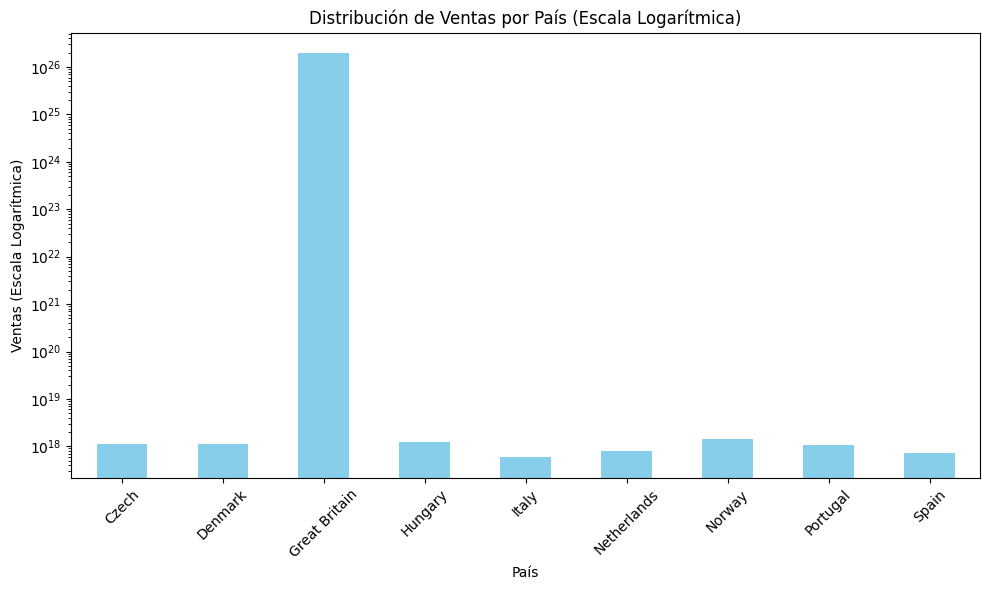

In [30]:


# Convertir a float
data['AMOUNT'] = data['AMOUNT'].astype(float)

ventas_por_pais = data[data['SCENARIO'] == 'actual'].groupby('COUNTRY')['AMOUNT'].sum()
# Crear el gráfico de barras con escala logarítmica
plt.figure(figsize=(10, 6))
ventas_por_pais.plot(kind='bar', color='skyblue')

# Configuración del gráfico
plt.yscale('log')  # Cambiar el eje y a escala logarítmica
plt.title('Distribución de Ventas por País (Escala Logarítmica)')
plt.xlabel('País')
plt.ylabel('Ventas (Escala Logarítmica)')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para que sean más legibles
plt.tight_layout()  # Ajustar el diseño para que no se corten las etiquetas

# Mostrar el gráfico
plt.show()

Graficamos los paises  frente al numero de ventas con gráfico de barras, ya que de esta forma se observa a la perfeción como se distribuyen los paises en función de sus ventas.

Lo graficamos en escala logaritmica porque las ventas en Gran Bretaña son excesivamente mayores que las de el resto de paises, si no lo hicieramos en esta escala el resto de paises pasarían desapercividos.

## Distribución de ventas por cada mes y año.

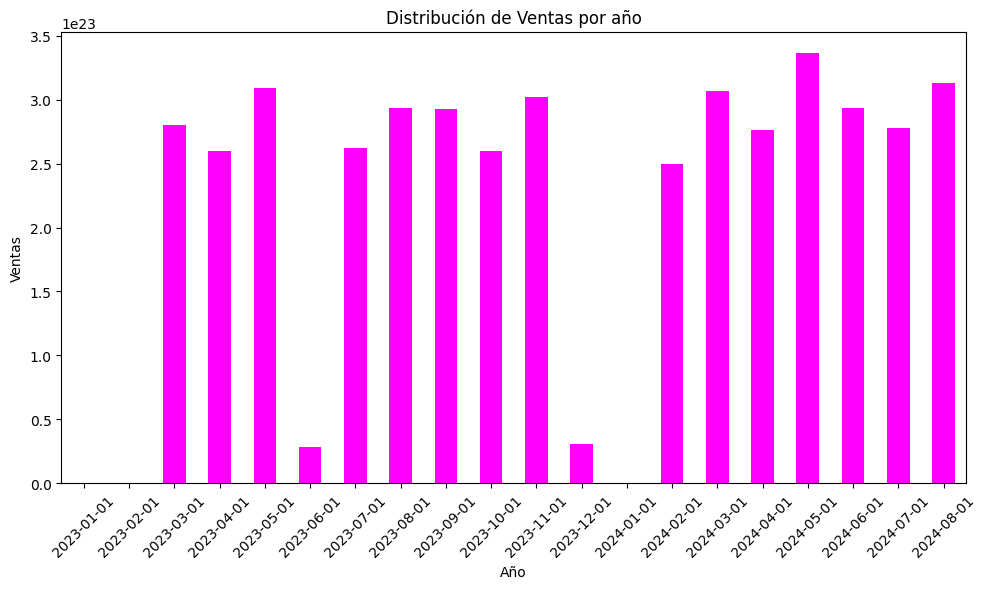

In [29]:
# Agrupar los datos por fecha y contar el número de ventas (puedes usar la suma si tienes montos)
ventas_por_fecha = data[data['SCENARIO'] == 'actual'].groupby('fecha')['AMOUNT'].mean()

# Crear el gráfico de barras con escala logarítmica
plt.figure(figsize=(10, 6))
ventas_por_fecha.plot(kind='bar', color='magenta')

# Configuración del gráfico
plt.title('Distribución de Ventas por año')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para que sean más legibles
plt.tight_layout()  # Ajustar el diseño para que no se corten las etiquetas

# Mostrar el gráfico
plt.show()

Tras graficar las ventas respecto a los meses podemos observar como hay algunos meses en los que no hay datos, esto puede que nos complique en un futuro la comprensión o la búsqueda de tendencias y estacionalidad.

## Distribución de ventas en cada marca

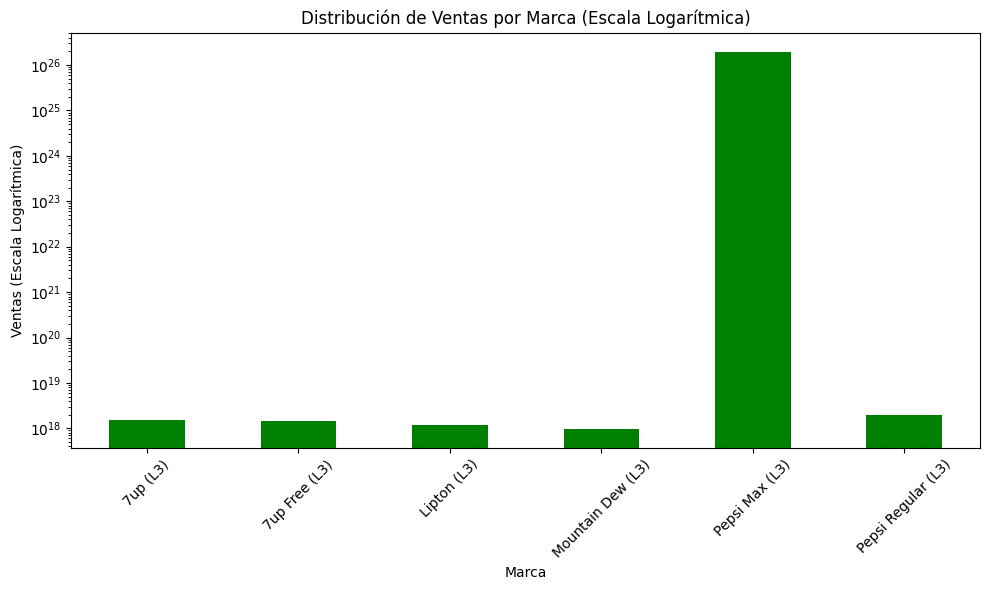

In [32]:
# Agrupar los datos por fecha y contar el número de ventas (puedes usar la suma si tienes montos)
ventas_por_marca = data[data['SCENARIO'] == 'actual'].groupby('SUBBRAND')['AMOUNT'].sum()

# Crear el gráfico de barras con escala logarítmica
plt.figure(figsize=(10, 6))
ventas_por_marca.plot(kind='bar', color='green')

# Configuración del gráfico
plt.yscale('log')  # Cambiar el eje y a escala logarítmica
plt.title('Distribución de Ventas por Marca (Escala Logarítmica)')
plt.xlabel('Marca')
plt.ylabel('Ventas (Escala Logarítmica)')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para que sean más legibles
plt.tight_layout()  # Ajustar el diseño para que no se corten las etiquetas

# Mostrar el gráfico
plt.show()

Una vez graficamos las marcas respecto a las ventas de cada una de ellas, podemos observar como claramente, la marca de Pepsi Max tienen cientos mas de ventas.


En este apartado pasa lo mismo que en la distribución de ventas por año, parece ser que hay muchas mas ventas de Pepsi Max o al menos tenemos muchos mas datos de esas ventas, por ello, tenemos que ponerlo en una escala logáritmica para que se pueda apreciar las ventas en el resto de marcas.

## Tendencia y estacionalidad del país con menos Ventas.

Primero queremos confirmar que el país con menos ventas es Italia.

In [31]:
ventas_por_pais

,AMOUNT
COUNTRY,
Czech,1.116373e+18
Denmark,1.122039e+18
Great Britain,1.969700e+26
Hungary,1.260773e+18
Italy,5.815434e+17
Netherlands,8.067665e+17
Norway,1.414509e+18
Portugal,1.089429e+18
Spain,7.213780e+17


Una vez confirmado podemos comenzar con el apartado.

<ipython-input-33-5da5dee57916>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italy_data['fecha'] = pd.to_datetime(italy_data['fecha'])


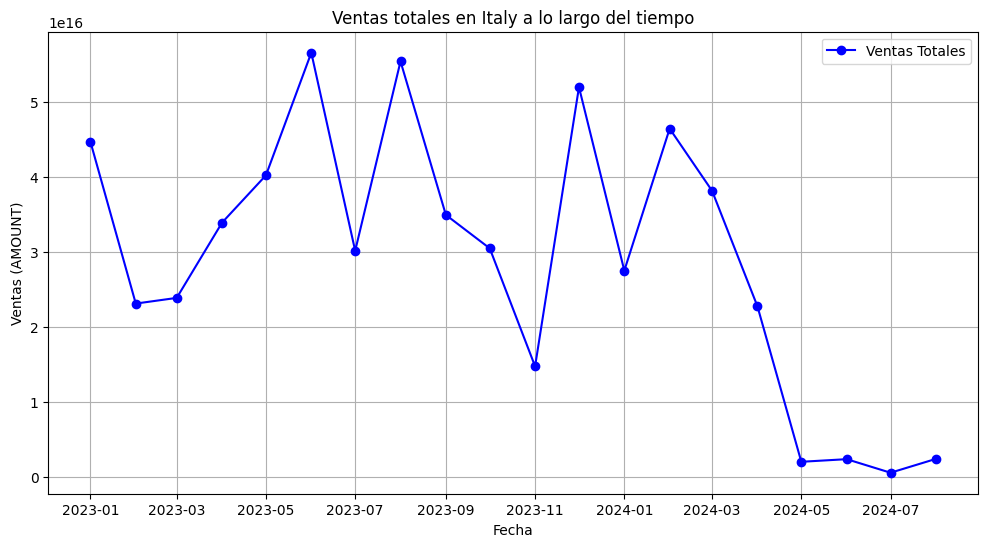

In [33]:
# Filtrar los datos para el país 'Italy'
italy_data = data[(data['COUNTRY'] == 'Italy') & (data['SCENARIO'] == 'actual')]

# Asegurarse de que la columna 'fecha' esté en formato de fecha
italy_data['fecha'] = pd.to_datetime(italy_data['fecha'])

# Sumar las ventas (AMOUNT) de cada SUBBRAND en cada fecha
italy_sales_sum = italy_data.groupby('fecha')['AMOUNT'].sum().reset_index()

# Ordenar los datos por fecha
italy_sales_sum = italy_sales_sum.sort_values(by='fecha')

# Graficar el total de ventas en un gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(italy_sales_sum['fecha'], italy_sales_sum['AMOUNT'], color='blue', marker='o', label='Ventas Totales')

# Etiquetas y título del gráfico
plt.title('Ventas totales en Italy a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas (AMOUNT)')
plt.grid(True)
plt.legend()
plt.show()

Después de graficar las ventas de Italia de todos los productos respecto del tiempo. Aparte de esta tendencia no absoluta no encontramos ningun tipo de estacionalidad en las ventas italianas.

## Tendencia y estacionalidad de la marca con más ventas

En este apartado no nos hace falta confirmar nada puesto que las ventas de Pepsi MAX eran claramente la marca con más ventas.

<ipython-input-34-43063228a67a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pepsi_max_data['fecha'] = pd.to_datetime(pepsi_max_data['fecha'])


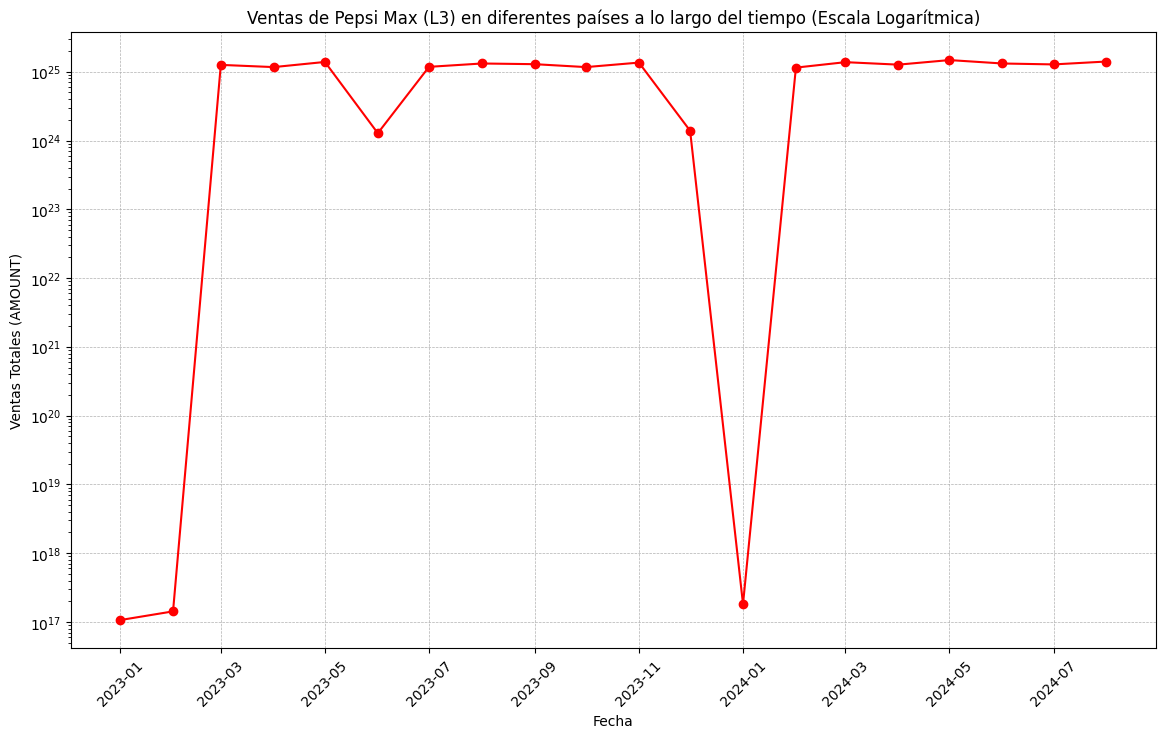

In [34]:
# Filtrar los datos para la submarca 'Pepsi Max (L3)'
pepsi_max_data = data[(data['SUBBRAND'] == 'Pepsi Max (L3)') & (data['SCENARIO'] == 'actual')]

# Asegurarse de que la columna 'fecha' esté en formato de fecha
pepsi_max_data['fecha'] = pd.to_datetime(pepsi_max_data['fecha'])

# Agrupar las ventas por fecha y sumar las ventas
ventas_por_fecha = pepsi_max_data.groupby('fecha')['AMOUNT'].sum().reset_index()

# Crear un gráfico de dispersión de las ventas totales por fecha
plt.figure(figsize=(14, 8))

plt.plot(ventas_por_fecha['fecha'], ventas_por_fecha['AMOUNT'], marker='o', linestyle='-', color='red')

# Establecer la escala logarítmica en el eje Y
plt.yscale('log')
# Etiquetas y título del gráfico
plt.title('Ventas de Pepsi Max (L3) en diferentes países a lo largo del tiempo (Escala Logarítmica)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales (AMOUNT)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

plt.show()

Con el gráfico anterior comprobamos como los pocos datos que habían en el primer mes son de gran notariedad. Esto podría indicar posibles eventos externos o problemas en los datos de ventas que afectaron de forma abrupta.

Las ventas de "Pepsi Max (L3)" muestran una tendencia de estabilidad en los valores altos, con una ligera inclinación hacia el crecimiento. Podría considerarse que hay patrones de estacionalidad poco definidos debidas a las caídas puntuales (posibles anomalías) en enero de con la recuperación posterior. Podremos ver como en el primer mes de cada año se encuentran los valores mas bajos en las ventas de cada año.

## Comparación de Predicciones, Valores Reales y MAE por Fecha en España.

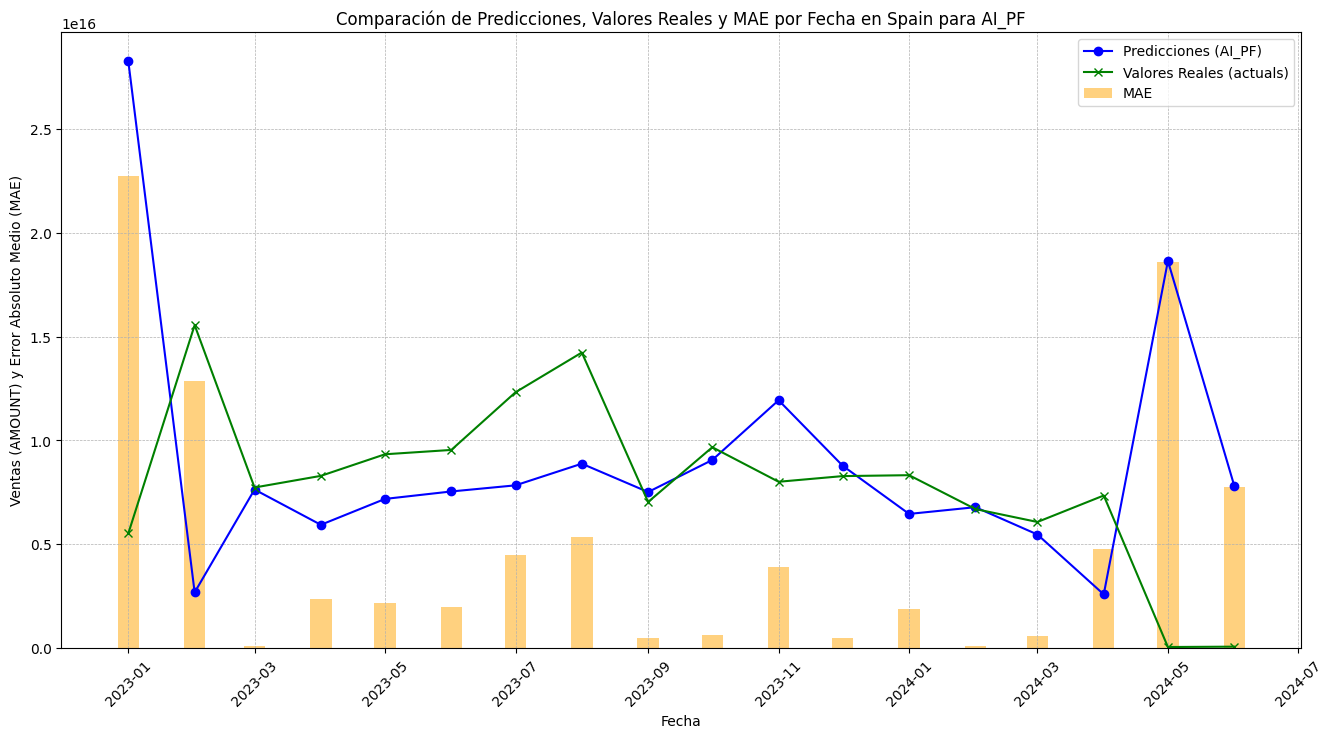

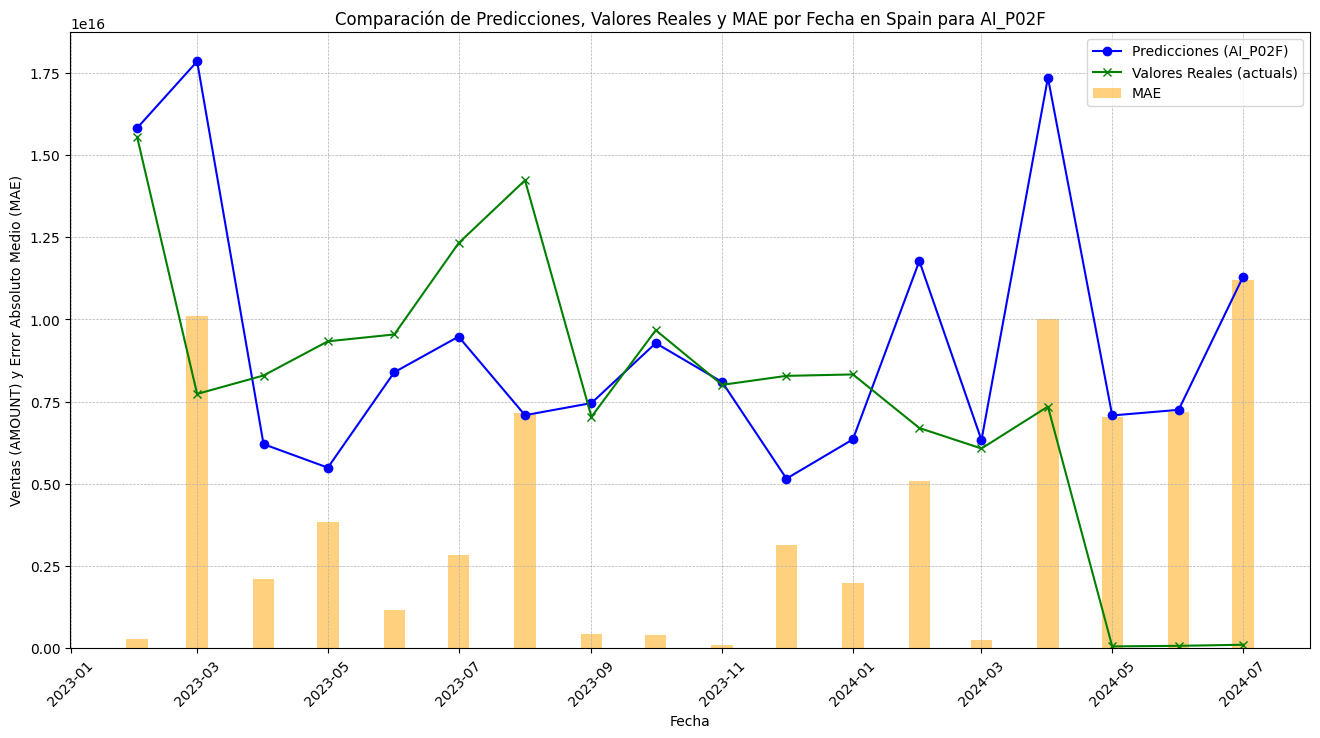

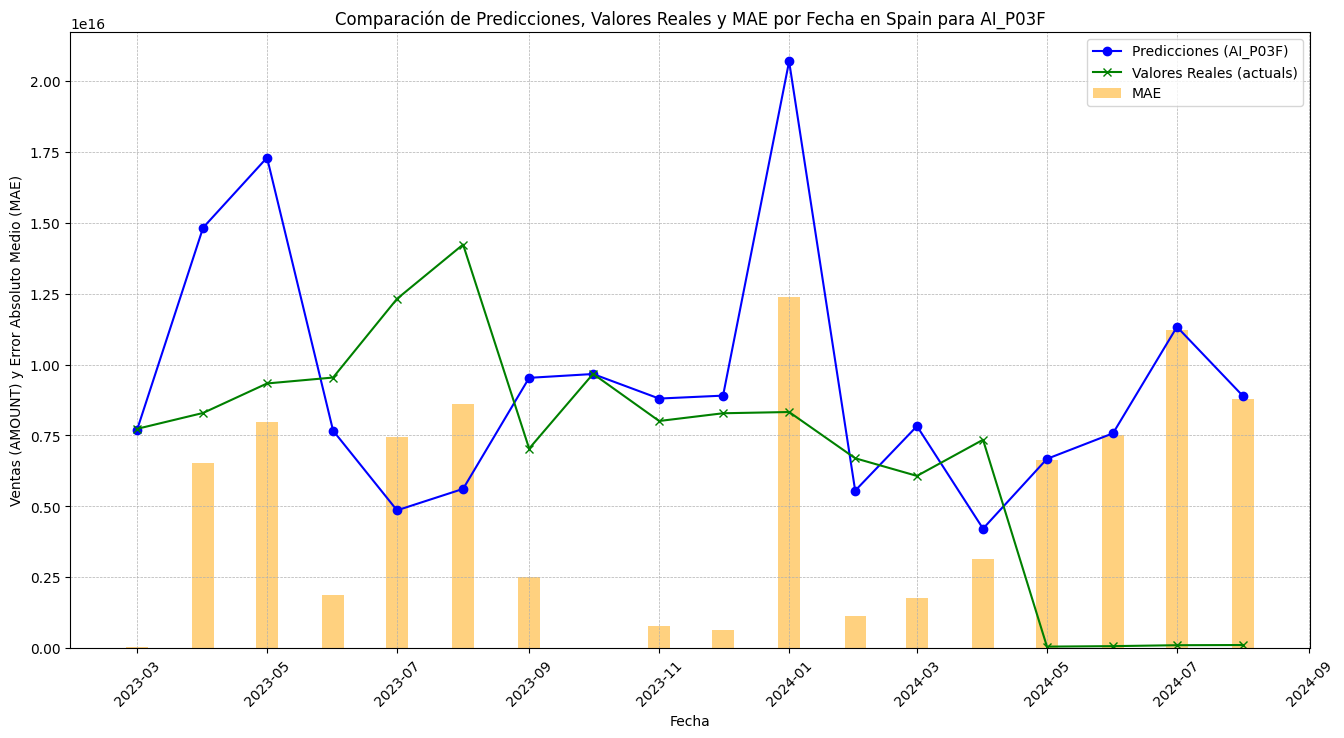

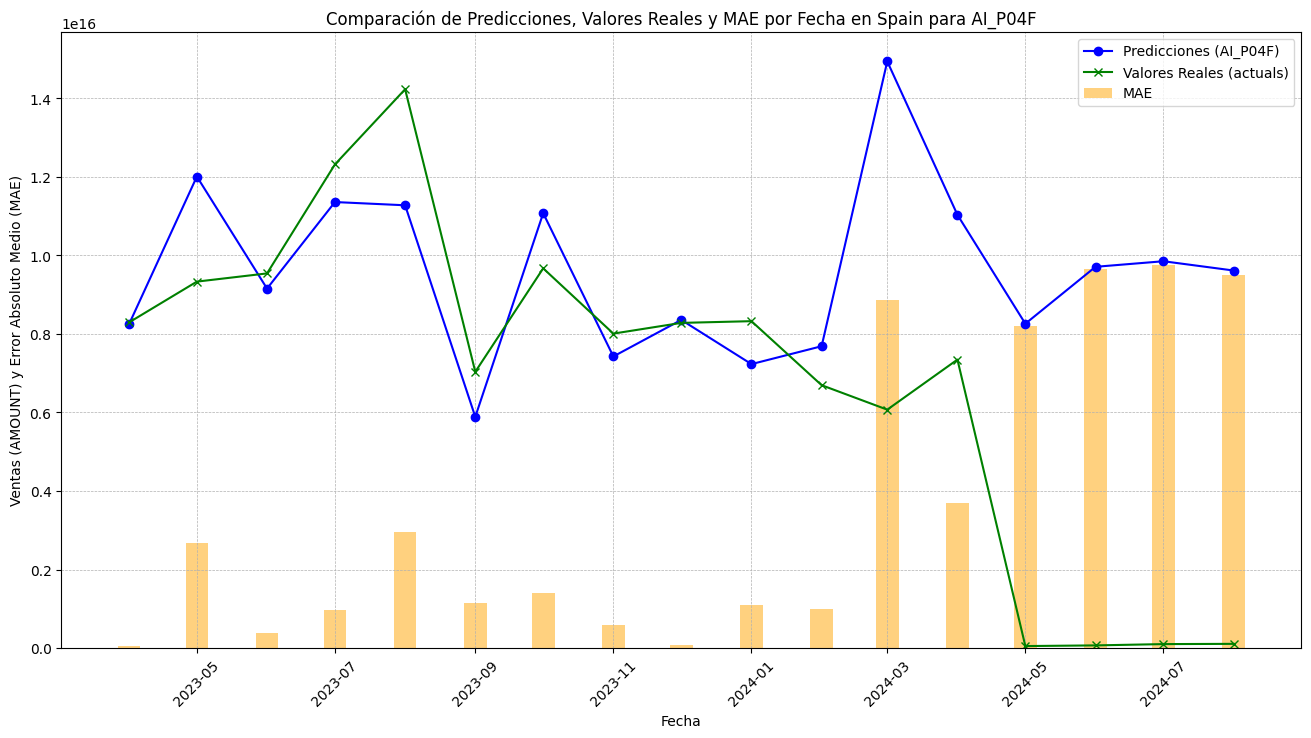

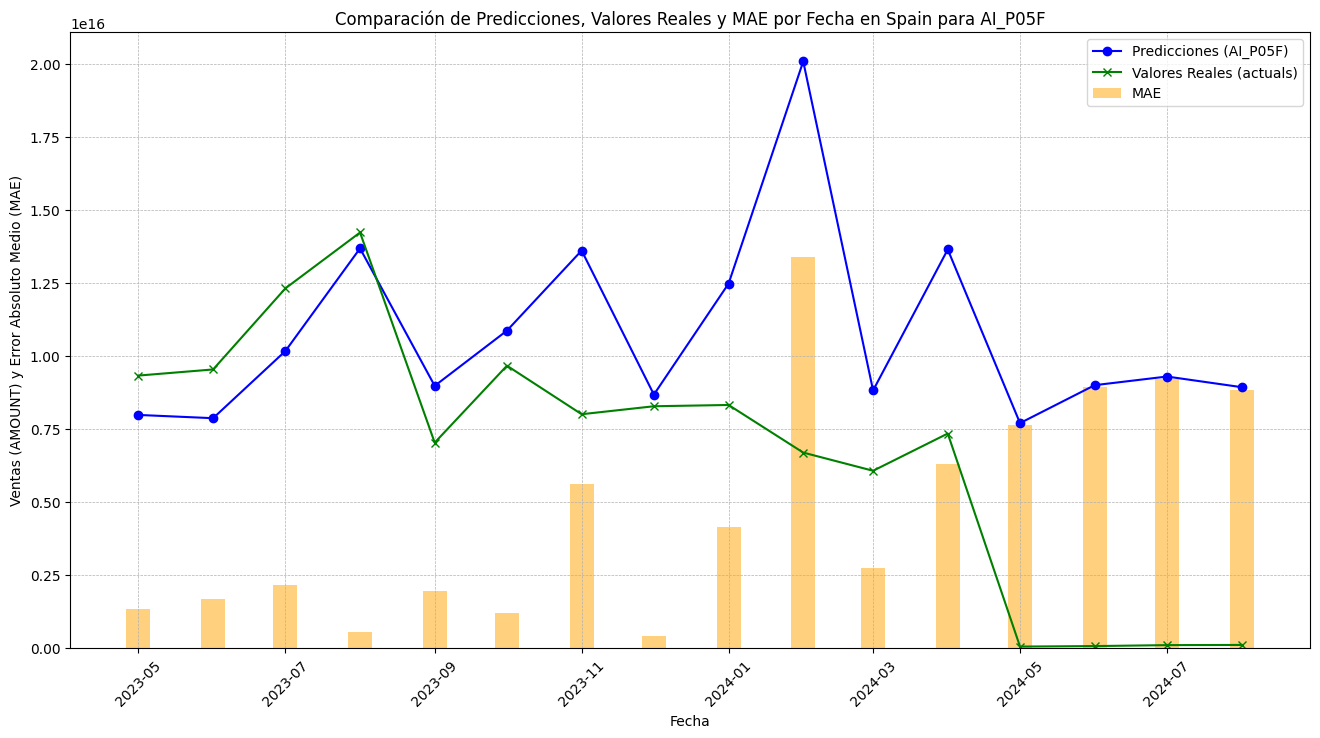

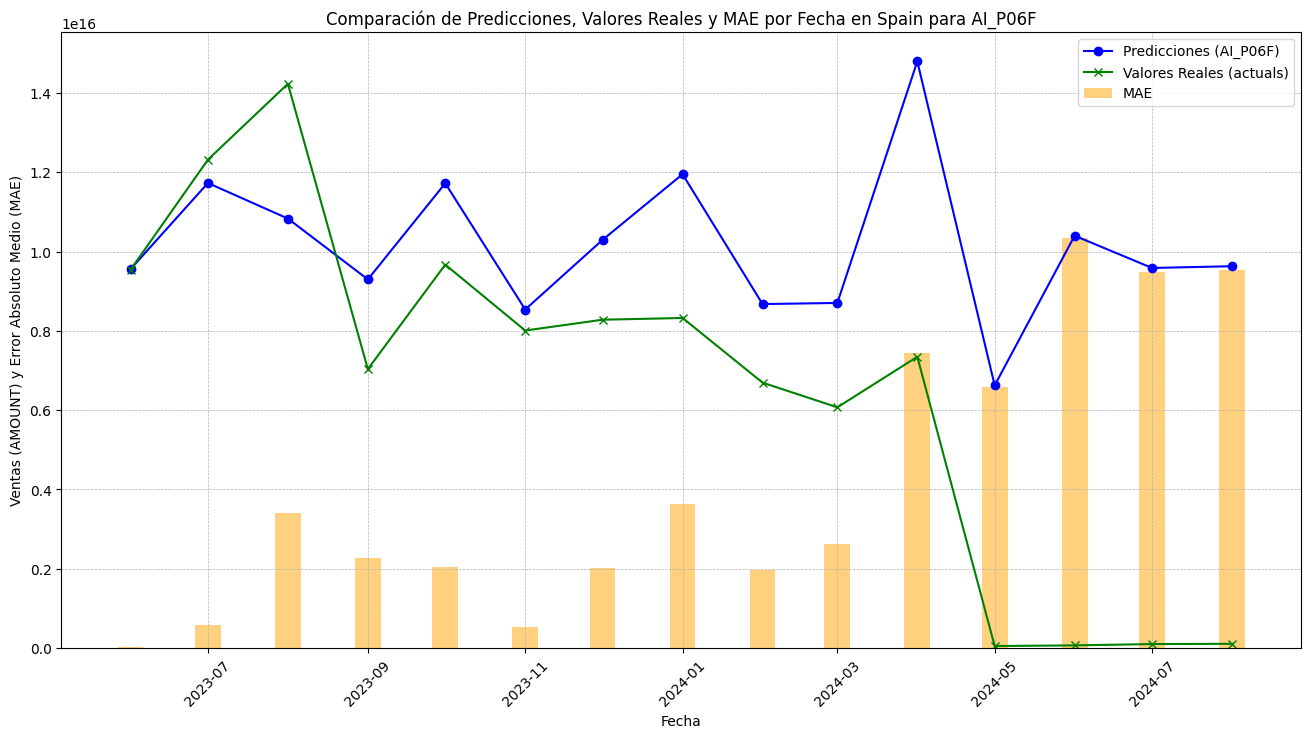

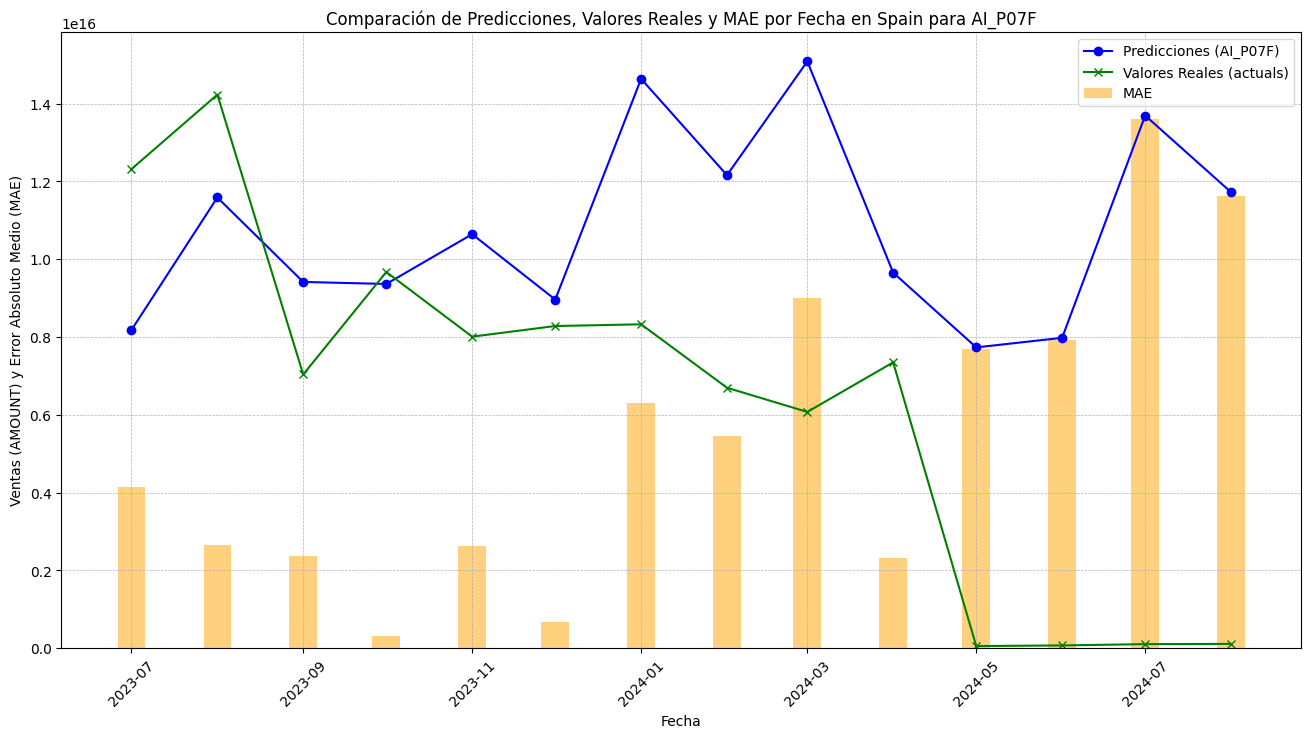

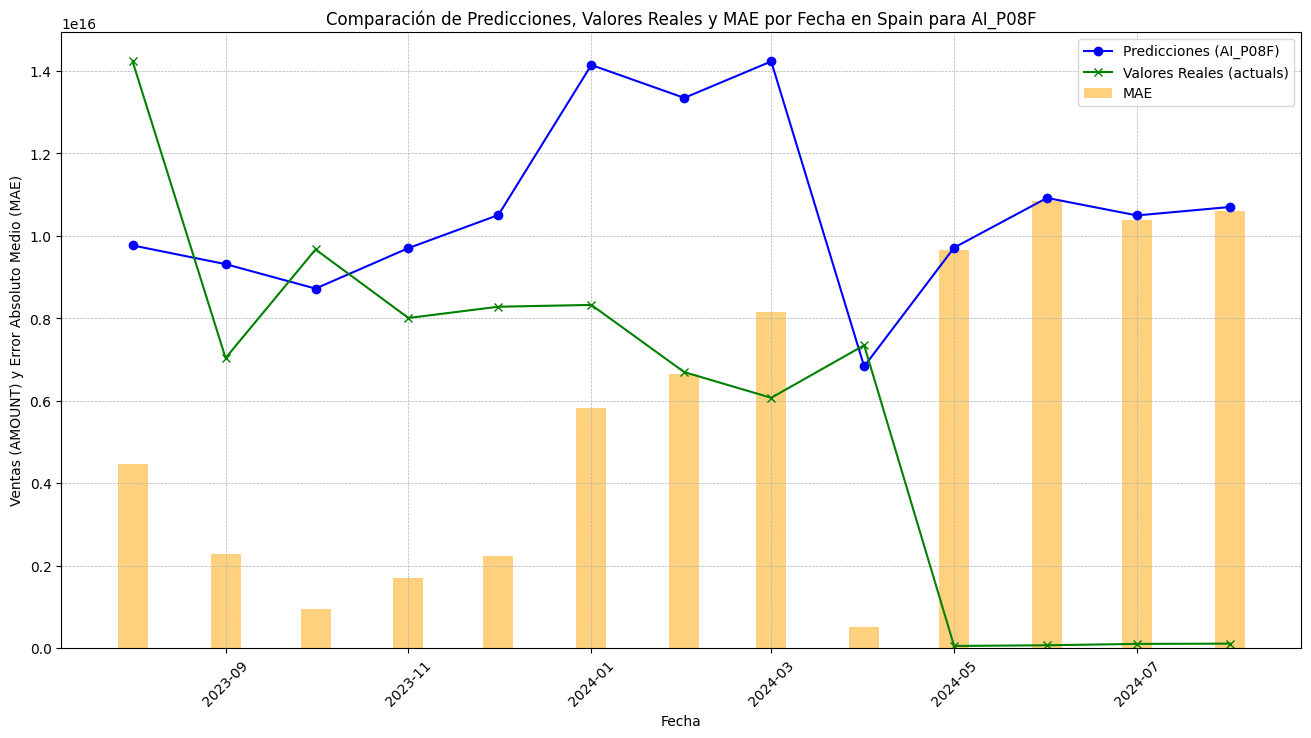

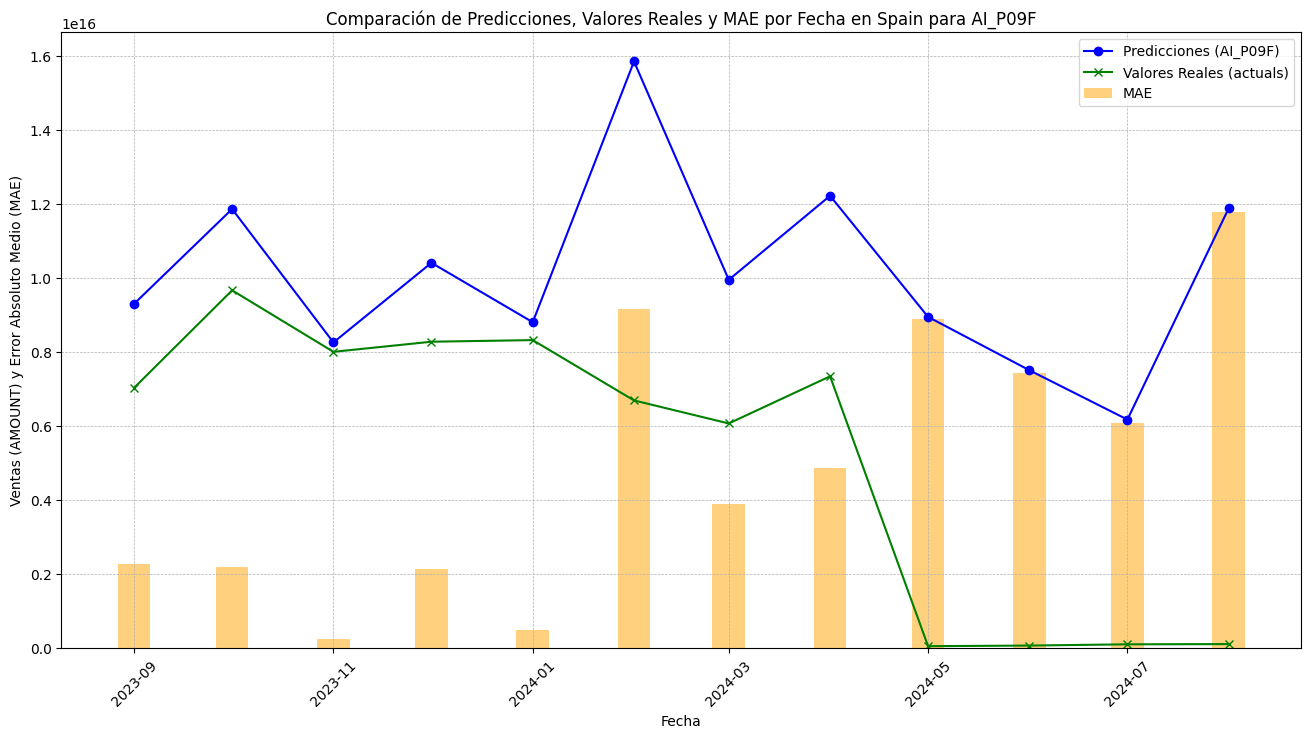

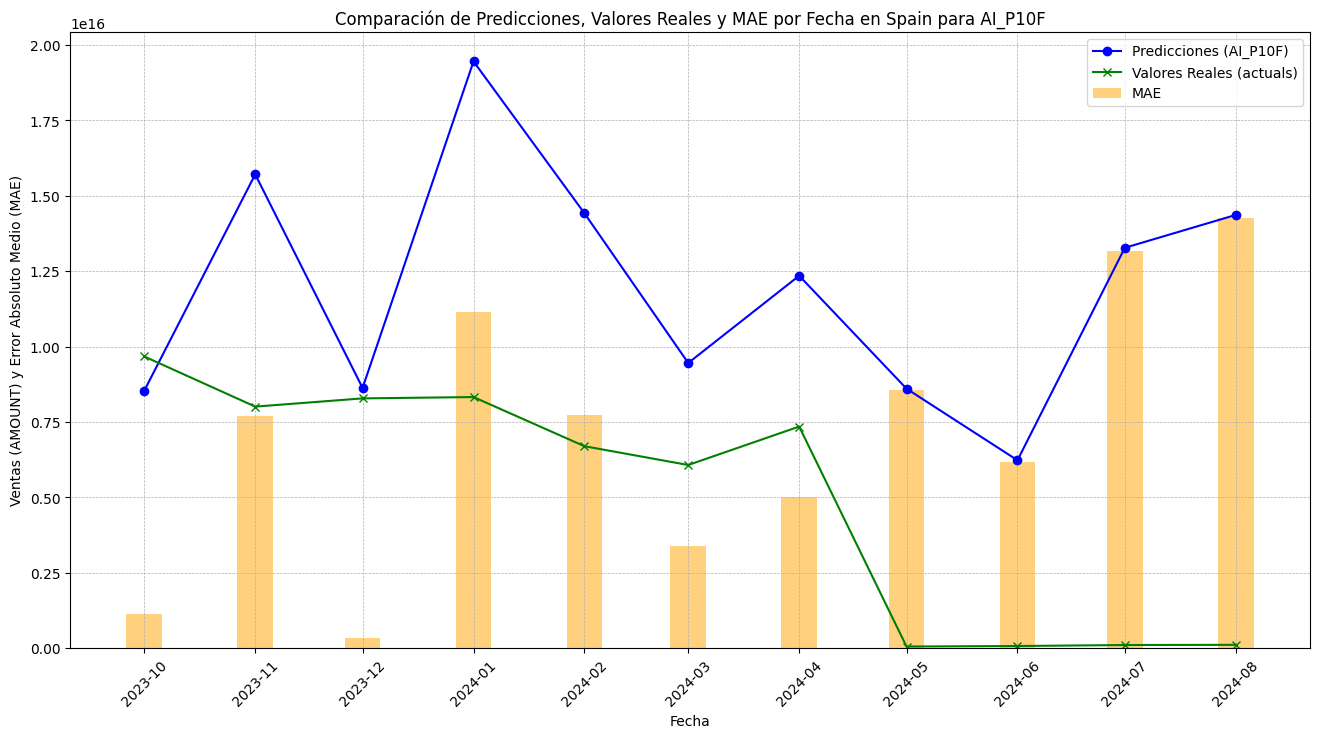

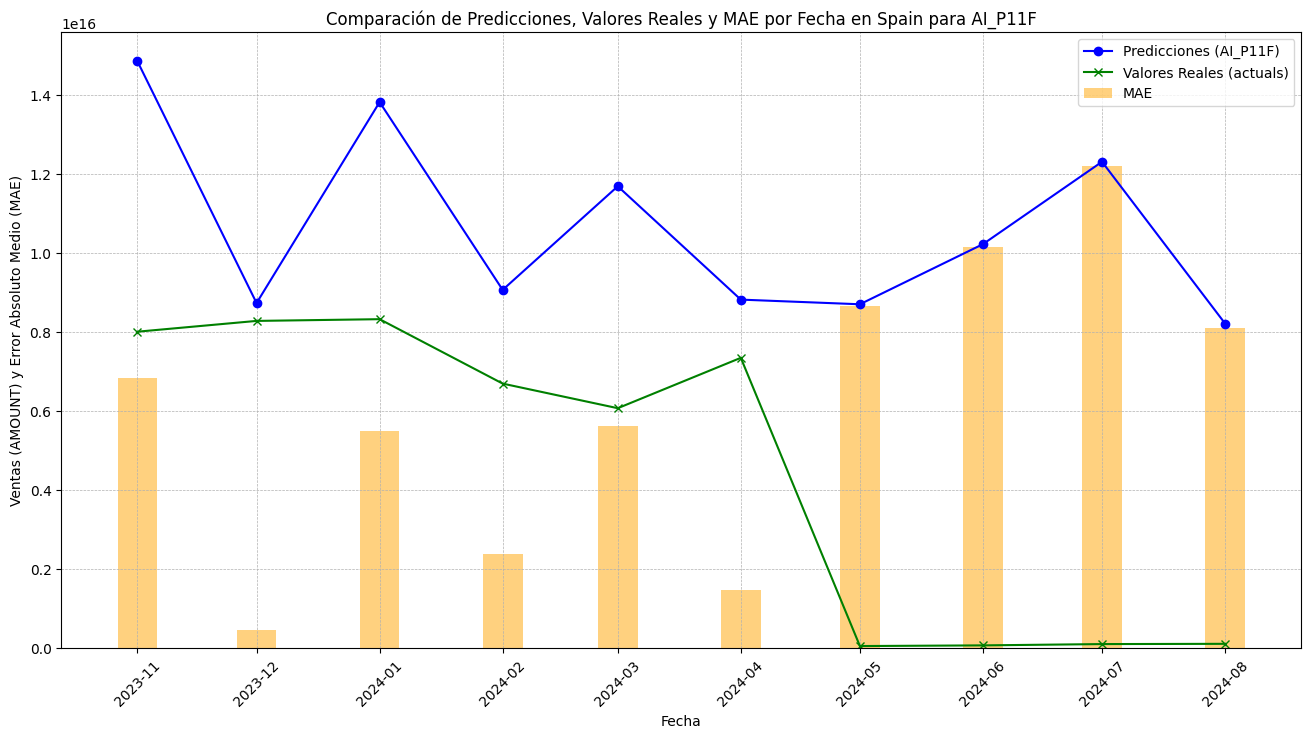

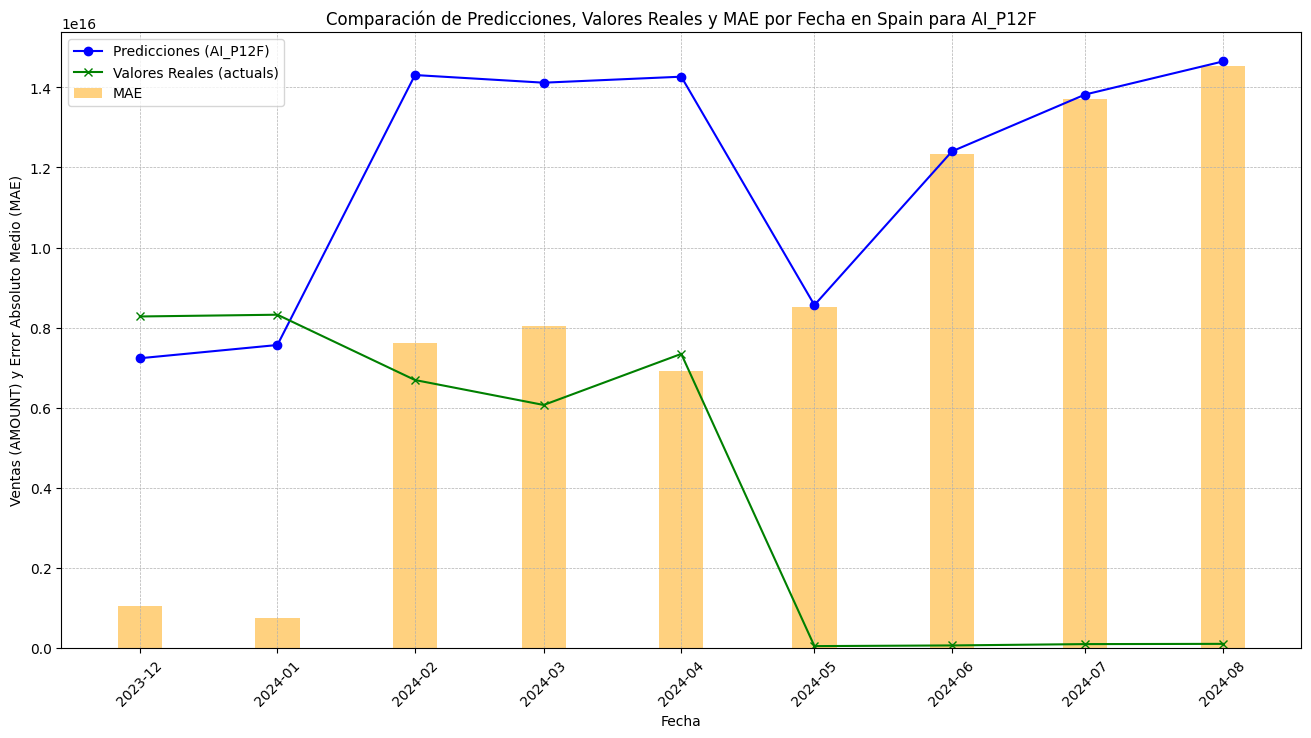

In [37]:
forecast_order = ['AI_PF', 'AI_P02F', 'AI_P03F', 'AI_P04F', 'AI_P05F', 'AI_P06F', 'AI_P07F',
                  'AI_P08F', 'AI_P09F', 'AI_P10F', 'AI_P11F', 'AI_P12F']

# Filtrar los datos solo para el país 'Spain' y escenario 'actuals'
ventas_actual = data[(data['SCENARIO'] == 'actual') & (data['COUNTRY'] == 'Spain')].groupby('fecha')['AMOUNT'].mean().reset_index()
ventas_actual = ventas_actual.rename(columns={'AMOUNT': 'AMOUNT_real'})

# Iterar sobre cada valor de forecast en forecast_order y generar un gráfico
for forecast in forecast_order:
    # Filtrar los datos para el forecast actual
    ventas_forecast = data[(data['SCENARIO'] == 'AI_forecast') & (data['COUNTRY'] == 'Spain') & (data['FORECAST'] == forecast)]
    ventas_forecast = ventas_forecast.groupby('fecha')['AMOUNT'].mean().reset_index()
    ventas_forecast = ventas_forecast.rename(columns={'AMOUNT': 'AMOUNT_pred'})

    # Combinar ambos DataFrames en uno solo basado en la fecha
    df_combined = pd.merge(ventas_forecast, ventas_actual, on='fecha', how='inner')

    # Calcular el error absoluto (MAE) en cada fecha
    df_combined['ABS_ERRR'] = abs(df_combined['AMOUNT_pred'] - df_combined['AMOUNT_real'])

    # Crear el gráfico
    plt.figure(figsize=(16, 8))

    # Línea de predicciones
    plt.plot(df_combined['fecha'], df_combined['AMOUNT_pred'], label=f'Predicciones ({forecast})', color='blue', marker='o')

    # Línea de valores reales
    plt.plot(df_combined['fecha'], df_combined['AMOUNT_real'], label='Valores Reales (actuals)', color='green', marker='x')

    # Barras de MAE
    plt.bar(df_combined['fecha'], df_combined['ABS_ERRR'], color='orange', alpha=0.5, label='MAE', width=10)

    # Etiquetas y título del gráfico
    plt.title(f'Comparación de Predicciones, Valores Reales y MAE por Fecha en Spain para {forecast}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas (AMOUNT) y Error Absoluto Medio (MAE)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()

    # Mostrar el gráfico
    plt.show()

Los gráficos sugieren que, en los datos de ventas de España, hay una considerable variabilidad tanto en el volumen de ventas como en la exactitud con la que se registran (representada por los MAE). Esto podría estar relacionado con factores específicos del mercado o variaciones en la metodología de captura de datos. Además, la presencia de ciertos picos y valles en ambos, ventas y MAE, podría indicar áreas donde se podría investigar más a fondo para entender los factores detrás de estas fluctuaciones.

Los gráficos muestran que cada uno de los valores de AI_forecast no siguen una relación estable con los valores reales y en algun periodo se muestra como el MAE toma valores muy altos. Esta inestavilidad podría interpretarse como una señal de que los valores de AI_forecast no reflejan un comportamiento real de las ventas.

Si estos datos correspondieran a un modelo de predicción sabríamos por el MAE, representado por las barras naranjas, que es notablemente alto en muchas de las fechas, especialmente en las últimas, es indicativo de que el modelo necesita ajustes para acercarse mejor a las ventas reales.